# Data Quality Wärmepumpendaten

Dieses Skript behandelt die Verbrauchsdaten der 36 Lastprofile im Detail und geht auf mögliche Unstimmigkeiten und Qualitätsprobleme ein

Struktur:

        1) Datenverfügbarkeit Allgemein

        2) Visualisierung der Lastverläufe

        3) Aggregierter Lastverlauf mit Betrachtung des Einfluss der Wochentage und der Betriebsmodi

        4) Weitere Gebäudeinformationen

____

#### Imports

In [22]:
import h5py
import pandas as pd
import numpy as np
import pickle 
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import re
import matplotlib.dates as mdates

pd.options.mode.chained_assignment = None 

#### Globale Variablen

In [5]:
INDEX_START = 1525270500
INDEX_START_2 = 1528965000
COLUMNS = ['P_TOT', 'Q_TOT', 'S_TOT', 'PF_TOT']

#### Einlesen der Daten

In [6]:
#read in data
with open('Data/heatpump/data_heatpump.pkl', 'rb') as f:
    load_dict = pickle.load(f)

----

# 1. Datenverfügbarkeit Allgemein

#### Erstellen eines Dataframes, welcher zur Analyse fehlender bzw. nan Zellen dient

Jede Zelle wird betrachtet und im Falle fehlender Werte wird diese als 0, bzw. als 1 für vorhandene Werte gewertet

In [8]:
def check_nan(x):
    if x >= 0:
        return 1
    else: 
        return 0

In [28]:
df_result = load_dict['SFH10']['index'].to_frame()
for df in load_dict:
    load_dict[df][df] = load_dict[df]['P_TOT'].apply(check_nan)
    df_result = pd.concat([df_result, load_dict[df][df]], axis=1)
df_result.set_index('index', inplace=True)
df_result

,SFH10,SFH11,SFH12,SFH14,SFH16,SFH17,SFH18,SFH19,SFH20,SFH21,...,SFH40,SFH5,SFH6,SFH7,SFH8,SFH9,SFH13,SFH15,SFH26,SFH33
index,,,,,,,,,,,,,,,,,,,,,
1514764800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514765700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514766600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514767500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514768400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609454700,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
1609455600,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
1609456500,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1


In [29]:
def plot_data_availability_histogramm(df):
    # Datenverfügbarkeit berechnen
    data_availability = df.mean(axis=0)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Farben festlegen
    colors = ['#ff9999' if value < 1 else '#66b266' for value in data_availability]

    # Horizontales Balkendiagramm zeichnen
    data_availability.plot(kind='barh', color=colors, ax=ax)

    # Achsentitel und Plot-Titel hinzufügen
    ax.set_title('Datenverfügbarkeit')
    ax.set_ylabel('Objekte')
    ax.set_xlabel('Verfügbarkeit in %')
    ax.set_xlim(0, 1)  # x-Achse auf den Bereich 0 bis 1 setzen

    # Anzeigen
    plt.tight_layout()
    plt.show()
    
def plot_data_availability(data):
    df = data.copy()
    # Datenkonvertierung: Unix-Timestamp zu Datum
    df.index = pd.to_datetime(df.index, unit='s')
    print(df.index[0])

    # Reihenfolge der Spalten nach den Zahlen in den Objektbezeichnungen sortieren
    sorted_columns = sorted(df.columns, key=lambda x: int(x.replace("SFH", "")))

    # Prozentsätze für jede Spalte berechnen
    percentages = (df.sum() / len(df) * 100).round(2)
    percentages = percentages[sorted_columns]

    # Plot-Einstellungen, Verkleinerung der Figur
    fig, ax = plt.subplots(figsize=(7, 8))  # Kleinere Figurgröße

    # Durch jede sortierte Spalte iterieren und Datenverfügbarkeit zeichnen
    for i, column in enumerate(sorted_columns):
        # Datenverfügbarkeit
        ax.fill_between(df.index, i, i + 1, where=(df[column] == 1), color='#66D37A', step='mid')
        # Fehlende Daten
        ax.fill_between(df.index, i, i + 1, where=(df[column] == 0), color='#FF5252', step='mid')
        # Prozentsatz neben jedem Balken hinzufügen (mit zusätzlichem Leerzeichen und Abstand nach rechts)
        ax.text(df.index[-1] + pd.Timedelta(days=1), i + 0.5, f" {percentages[column]}%", verticalalignment='center', horizontalalignment='left')

    # Einstellungen
    # Anpassung der x-Limits, um den Platz für die Prozentsätze zu berücksichtigen
    ax.set_xlim([df.index.min(), df.index.max() + pd.Timedelta(days=1)])  # Reduzierter Platz für Prozentsätze
    ax.set_ylim([0, len(sorted_columns)])
    ax.set_yticks(np.arange(len(sorted_columns)) + 0.5)
    ax.set_yticklabels(sorted_columns)
    ax.set_title("Data Availability")
    ax.set_xlabel("Timestamps")
    ax.set_ylabel("Objects")

    # Farblegende hinzufügen
    ax.legend(handles=[plt.Line2D([0], [0], color='#66D37A', label='Available'),
                    plt.Line2D([0], [0], color='#FF5252', label='Missing')], loc='upper right')

    # Erweiterte Datumseinstellungen für die X-Achse mit 3-monatigem Intervall
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

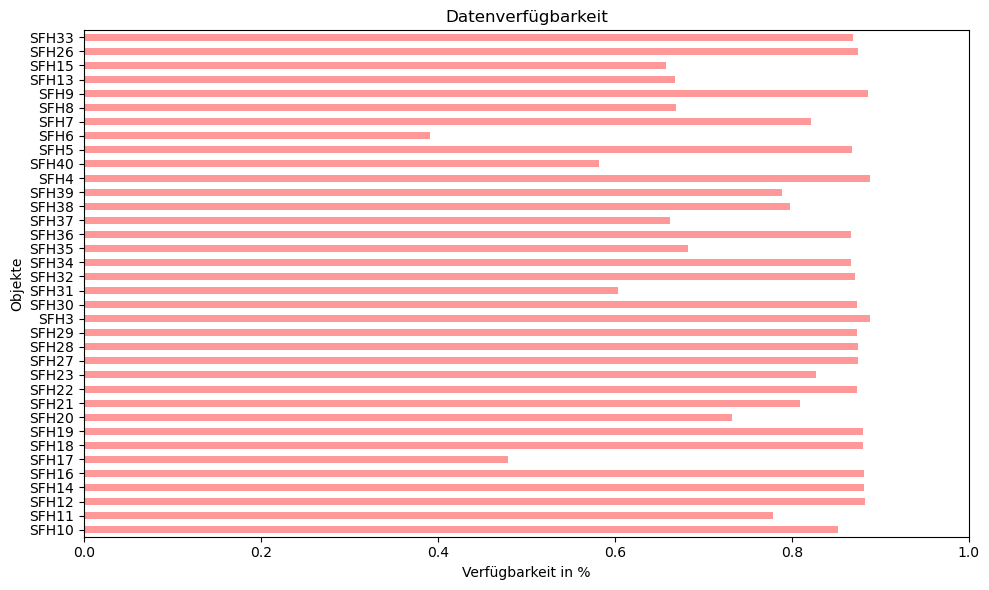

In [21]:
plot_data_availability_histogramm(df_result)

2018-01-01 00:00:00


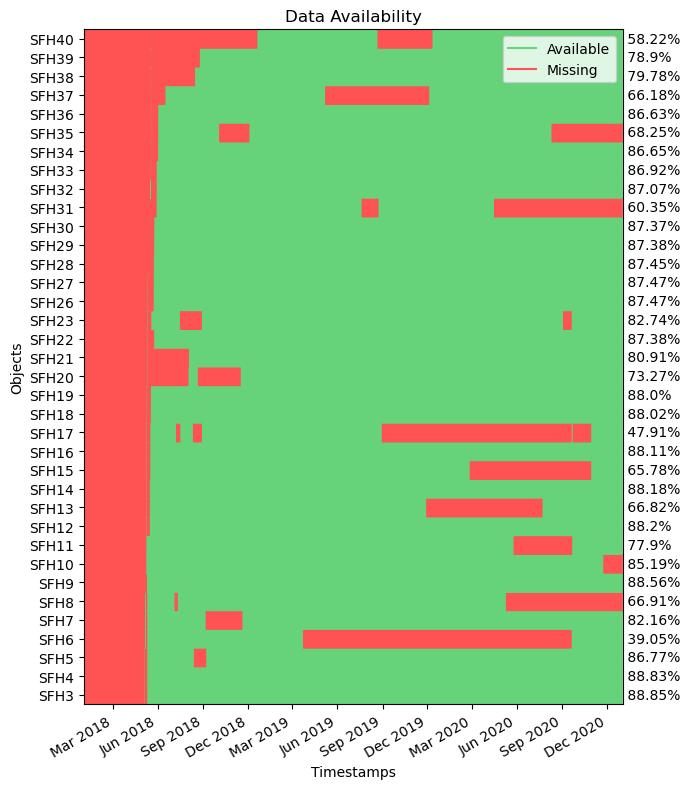

In [30]:
plot_data_availability(df_result)

#### Develop functions to analize intervalls with missing values

In [13]:
def get_missing_intervalls(df, column):
    # Gruppen von zusammenhängenden Nullen identifizieren
    df['group'] = (df[column] != df[column].shift()).cumsum()
    zero_groups = df[df[column] == 0].groupby('group')
    # Start- und Endindizes von zusammenhängenden Nullen ausgeben
    result = []
    for name, group in zero_groups:
        start_index = group.index[0]
        end_index = group.index[-1]
        result.append((start_index, end_index))

    return result

def get_missing_intervalls_length(tuple):
    length = tuple[1] - tuple[0]
    return length

In [15]:
df_10 = df_result['SFH10'].to_frame()
df_10.head(3)

,SFH10
index,
1514764800,0
1514765700,0
1514766600,0


In [14]:
get_missing_intervalls(df_10, 'SFH10')

[(1514764800, 1525595400), (1606263300, 1609458300)]

#### reduce dataframe to common start

Kriterium: bei mehr als 30 datensätzen sind Verbrauchsinformationen vorhanden

In [32]:
test = df_result[df_result.index >= 1525270500]

for row,value in test.iterrows():
    if test.loc[row].sum() > 30:
        print(">30: " + str(row))
        start_index = row
        break

df_final = df_result[df_result.index >= start_index]
df_final

>30: 1526464800


,SFH10,SFH11,SFH12,SFH14,SFH16,SFH17,SFH18,SFH19,SFH20,SFH21,...,SFH40,SFH5,SFH6,SFH7,SFH8,SFH9,SFH13,SFH15,SFH26,SFH33
index,,,,,,,,,,,,,,,,,,,,,
1526464800,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,0,1
1526465700,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,0,1
1526466600,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,0,1
1526467500,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,0,1
1526468400,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609454700,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
1609455600,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
1609456500,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1


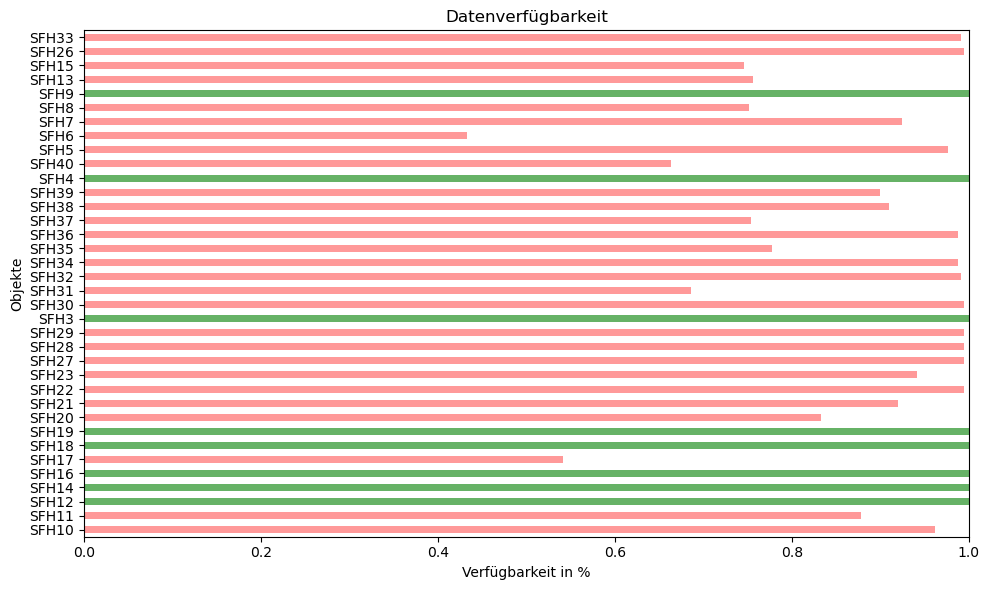

In [33]:
plot_data_availability_histogramm(df_final)

2018-05-16 10:00:00


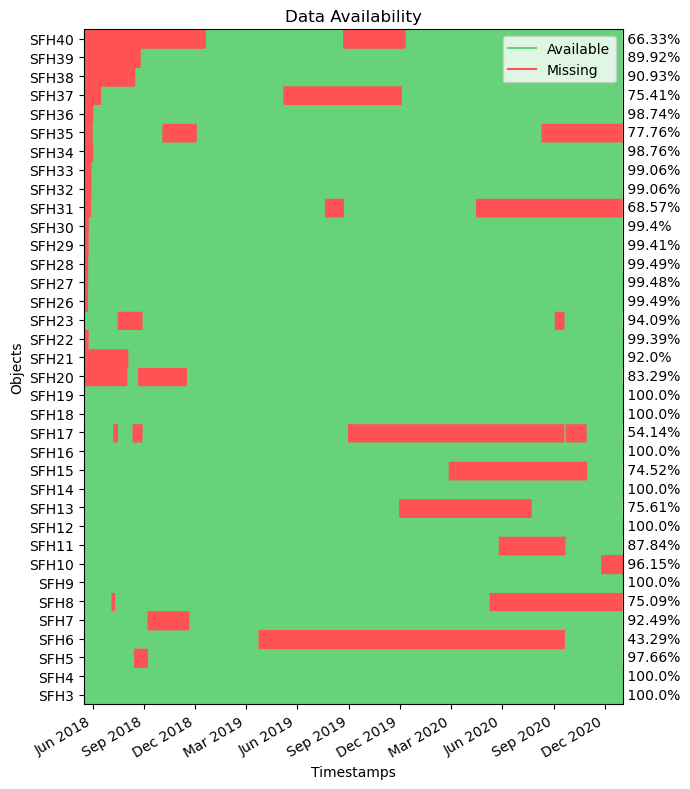

In [34]:
plot_data_availability(df_final)

2018-06-14 08:30:00


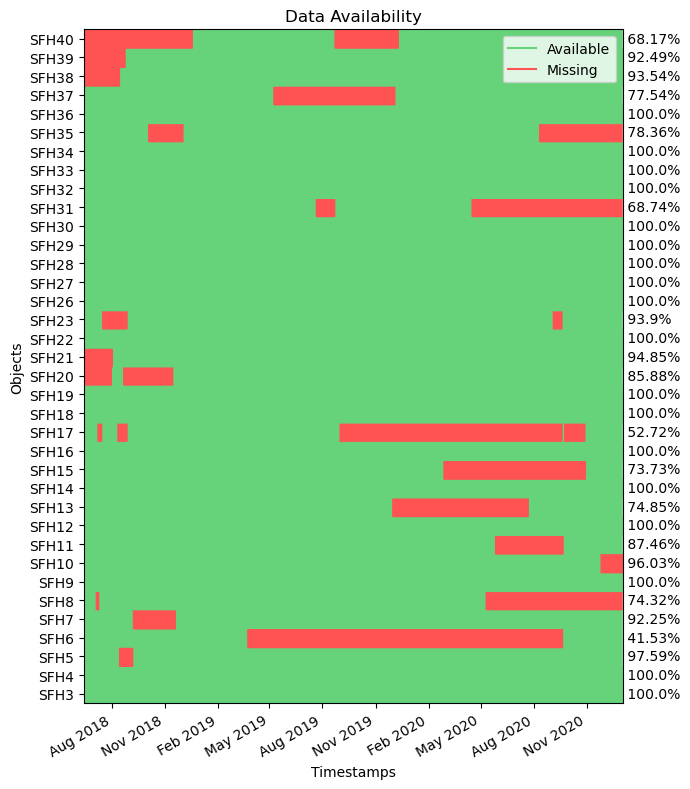

In [35]:
df_reduced = df_result[df_result.index >= 1528965000] # index from start of data availability of SFH37
plot_data_availability(df_reduced)

reduced to 27 datasets
2018-06-14 08:30:00


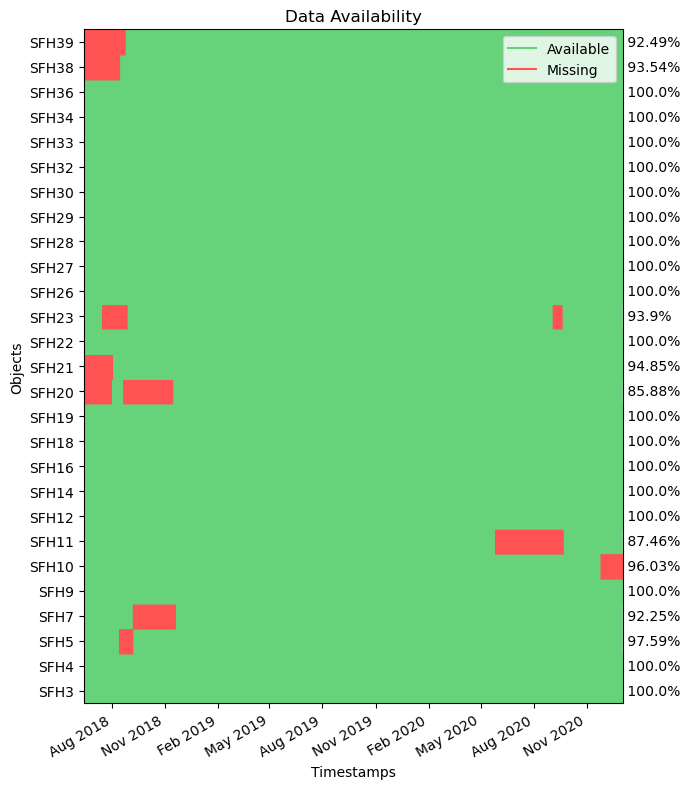

In [36]:
threshold = 0.85
column_list=[]
missing_list=[]
incomplete_list = []
complete_list = []
for column in df_reduced.columns:
    percentage = df_reduced[column].sum()/len(df_reduced)
    if percentage > threshold:
        if percentage != 1:
            incomplete_list.append(column)
        if percentage ==1: 
            complete_list.append(column)
        column_list.append(column)
    else:
        missing_list.append(column)

print('reduced to {} datasets'.format(len(column_list)))

plot_data_availability(df_reduced[column_list])

#### Analysis of missing intervalls

In [38]:
dict_intervalls = {}

df_result = df_result[df_result.index > INDEX_START_2]
for column in df_result.columns:
    if column in incomplete_list:
        df = df_result[column].to_frame()
        intervalls = get_missing_intervalls(df, column)
        dict_intervalls[column] = intervalls
        #print(column + ": " + str(intervalls))

#with open('Data/missing_intervalls_dict.pkl', 'wb') as f:
#    pickle.dump(dict_intervalls, f)

dict_intervalls

{'SFH10': [(1606263300, 1609458300)],
 'SFH11': [(1590465600, 1600556400)],
 'SFH20': [(1528965900, 1533017700), (1534894200, 1542208500)],
 'SFH21': [(1528965900, 1533106800)],
 'SFH23': [(1531748700, 1535373000), (1599182100, 1600462800)],
 'SFH38': [(1528965900, 1534167000)],
 'SFH39': [(1528965900, 1535008500)],
 'SFH5': [(1534202100, 1536142500)],
 'SFH7': [(1536276600, 1542512700)]}

In [40]:
print("complete list 100%: " + str(complete_list))
print("incomplete list >85%: " + str(incomplete_list))
print("insufficient list <85%: " + str(missing_list))

complete list 100%: ['SFH12', 'SFH14', 'SFH16', 'SFH18', 'SFH19', 'SFH22', 'SFH27', 'SFH28', 'SFH29', 'SFH3', 'SFH30', 'SFH32', 'SFH34', 'SFH36', 'SFH4', 'SFH9', 'SFH26', 'SFH33']
incomplete list >85%: ['SFH10', 'SFH11', 'SFH20', 'SFH21', 'SFH23', 'SFH38', 'SFH39', 'SFH5', 'SFH7']
insufficient list <85%: ['SFH17', 'SFH31', 'SFH35', 'SFH37', 'SFH40', 'SFH6', 'SFH8', 'SFH13', 'SFH15']


------

# 2. Visualisierung der Lastverläufe

Plot of all available data for whole timespan

In [63]:
def create_consumption_plot(data, name):
    df = data.reset_index()
    # Erstelle eine Figur mit sekundärer Y-Achse
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Füge die Kurven für P_TOT, Q_TOT, und S_TOT zur linken Y-Achse hinzu
    fig.add_trace(
        go.Scatter(x=df['index'], y=df['P_TOT'], name='P_TOT'),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df['index'], y=df['Q_TOT'], name='Q_TOT'),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df['index'], y=df['S_TOT'], name='S_TOT'),
        secondary_y=False,
    )
    # Füge die Kurve für PF_TOT zur rechten Y-Achse hinzu
    fig.add_trace(
        go.Scatter(x=df['index'], y=df['PF_TOT'], name='PF_TOT', line=dict(dash='dot')),
        secondary_y=True,
    )
    # Benenne die Achsen
    fig.update_xaxes(title_text='Zeit')
    fig.update_yaxes(title_text='P_TOT, Q_TOT, S_TOT', secondary_y=False)
    fig.update_yaxes(title_text='PF_TOT', secondary_y=True)
    # Füge einen Titel hinzu und passe das Layout an
    fig.update_layout(
        title_text='Zeitliche Darstellung der Werte - {}'.format(name),
        xaxis=dict(
            tickmode='auto',
            nticks=20,
            ticks='outside',
            tickson='boundaries',
            ticklen=20
        )
    )
    # Zeige die Figur an
    fig.show()

#create_consumption_plot(df_3, 'SFH3')

Resampled version

In [64]:
def create_resampled_consumption_plot(data, name):
    # Stelle sicher, dass 'index' in datetime umgewandelt wird und als Index gesetzt wird
    df = data.copy()
    df['index'] = pd.to_datetime(df['index'])
    df.set_index('index', inplace=True)

    # Resample der Daten auf 24-Stunden-Intervalle und berechne den Durchschnitt
    df_resampled = df.resample('24H').mean().reset_index()

    # Erstelle eine Figur mit sekundärer Y-Achse
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Füge die Kurven für P_TOT, Q_TOT, und S_TOT zur linken Y-Achse hinzu
    fig.add_trace(
        go.Scatter(x=df_resampled['index'], y=df_resampled['P_TOT'], name='P_TOT'),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=df_resampled['index'], y=df_resampled['Q_TOT'], name='Q_TOT'),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=df_resampled['index'], y=df_resampled['S_TOT'], name='S_TOT'),
        secondary_y=False,
    )

    # Füge die Kurve für PF_TOT zur rechten Y-Achse hinzu
    fig.add_trace(
        go.Scatter(x=df_resampled['index'], y=df_resampled['PF_TOT'], name='PF_TOT', line=dict(dash='dot')),
        secondary_y=True,
    )

    # Benenne die Achsen
    fig.update_xaxes(title_text='Zeit')
    fig.update_yaxes(title_text='P_TOT, Q_TOT, S_TOT', secondary_y=False)
    fig.update_yaxes(title_text='PF_TOT', secondary_y=True)

    # Füge einen Titel hinzu und passe das Layout an
    fig.update_layout(
        title_text='Zeitliche Darstellung der Werte mit 24-Stunden-Intervallen - {}'.format(name),
        xaxis=dict(
            tickmode='auto',
            nticks=20,
            ticks='outside',
            tickson='boundaries',
            ticklen=20
        )
    )

    # Zeige die Figur an
    fig.show()

In [65]:
def sort_key(string):
    # Finde alle Zahlen im String und verbinde sie
    number = int(re.search(r'\d+', string).group())
    return number

list_strings = list(load_dict.keys())
sorted_keys = sorted(list_strings, key=sort_key)

for key in sorted_keys[2:4]: #remove [0:5] to see all
    sub_df = load_dict[key]
    sub_df = sub_df[sub_df['index']>INDEX_START]
    sub_df.set_index('index', inplace=True)
    sub_df.index = pd.to_datetime(sub_df.index, unit='s')
    sub_df.reset_index(inplace=True)
    create_resampled_consumption_plot(sub_df, key)

### Plots pro Jahr

Normal

In [48]:
def plot_year(df_year, year, name):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Scatter(x=df_year['index'], y=df_year['P_TOT'], name='P_TOT'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df_year['index'], y=df_year['Q_TOT'], name='Q_TOT'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df_year['index'], y=df_year['S_TOT'], name='S_TOT'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df_year['index'], y=df_year['PF_TOT'], name='PF_TOT', line=dict(dash='dot')), secondary_y=True)
    
    # Update the layout for the subplot
    fig.update_yaxes(title_text='P_TOT, Q_TOT, S_TOT', secondary_y=False)
    fig.update_yaxes(title_text='PF_TOT', secondary_y=True)
    fig.update_xaxes(title_text='Zeit')

    # Füge einen Titel hinzu und passe das Layout an
    fig.update_layout(height=600, width=1200, title_text=f'Daten für das Jahr {year} - {name}')
    
    # Zeige die Figur an
    fig.show()

def create_plot_per_year(data, name, years=[2018,2019,2020]):
    df = data.copy()
    df['index'] = pd.to_datetime(df['index'])

    # Filtere die Daten nach Jahr
    for year in years:
        df_year = df[df['index'].dt.year == year]
        plot_year(df_year, year, name)

#create_plot_per_year(df_3, 'SFH3')

Resampled

In [51]:
# Funktion zur Erstellung der Plots mit 24-stündiger Auflösung
def create_resampled_plot_per_year(data, year, name):
    df = data.reset_index()
    df['index'] = pd.to_datetime(df['index'])
    df.set_index('index', inplace=True)
    # Resample der Daten auf 24-Stunden-Intervalle und berechne den Durchschnitt
    df_resampled = df.resample('24H').mean()
    
    # Filtere nur das gewünschte Jahr
    df_year = df_resampled[df_resampled.index.year == year]

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Füge die Daten zur Figur hinzu
    fig.add_trace(go.Scatter(x=df_year.index, y=df_year['P_TOT'], name='P_TOT'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df_year.index, y=df_year['Q_TOT'], name='Q_TOT'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df_year.index, y=df_year['S_TOT'], name='S_TOT'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df_year.index, y=df_year['PF_TOT'], name='PF_TOT', line=dict(dash='dot')), secondary_y=True)

    # Aktualisiere die Layout-Einstellungen
    fig.update_layout(title_text=f"Durchschnittliche Werte in 24-Stunden-Intervallen für das Jahr {year} - {name}",
                      height=600, width=1400)
    fig.update_yaxes(title_text='P_TOT, Q_TOT, S_TOT', secondary_y=False)
    fig.update_yaxes(title_text='PF_TOT', secondary_y=True)

    # Zeige die Figur an
    fig.show()

# Erzeuge die Plots für jedes Jahr
# for year in range(2018,2021,1):
    #create_resampled_plot_per_year(df_3, year, 'SFH3')

Mit gleitendem Mittelwert

In [52]:
def plot_with_moving_average(data, bez):
    # Angenommen, df ist Ihr DataFrame, der bereits geladen wurde und das Datum als Index hat.
    df=data.resample('24H').mean()

    # Erstellen Sie eine Subplot-Figur mit zwei Y-Achsen
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Hinzufügen der Linien für 'P_TOT', 'Q_TOT', und 'S_TOT' auf der linken Y-Achse
    fig.add_trace(go.Scatter(x=df.index, y=df['P_TOT'], name='P_TOT'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df.index, y=df['Q_TOT'], name='Q_TOT'), secondary_y=False)
    fig.add_trace(go.Scatter(x=df.index, y=df['S_TOT'], name='S_TOT'), secondary_y=False)

    # Hinzufügen der Linie für 'PF_TOT' auf der rechten Y-Achse
    fig.add_trace(go.Scatter(x=df.index, y=df['PF_TOT'], name='PF_TOT', marker_color='red'), secondary_y=True)

    # Berechnen des gleitenden Mittelwerts für 'P_TOT' und Hinzufügen als Linie
    df['P_TOT_SMA'] = df['P_TOT'].rolling(window=3).mean()
    fig.add_trace(go.Scatter(x=df.index, y=df['P_TOT_SMA'], name='P_TOT SMA', line=dict(color='firebrick', width=2, dash='dash')), secondary_y=False)

    # Update der Layouts für Achsen und Titel
    fig.update_layout(title_text="24h resampled Lastverlauf - {}".format(bez), title_x=0.5)
    fig.update_xaxes(title_text="", dtick='M1')
    fig.update_yaxes(title_text="P_TOT, Q_TOT, S_TOT [W, var, VA]", secondary_y=False)
    fig.update_yaxes(title_text="PF_TOT", secondary_y=True)

    # Anzeigen der Figur
    fig.show()

----

# 3. Aggregierter Lastverlauf

In [53]:
df_3 = load_dict["SFH3"]
df_3 = df_3[df_3['index']>INDEX_START]
df_3.set_index('index', inplace=True)
df_3.index = pd.to_datetime(df_3.index, unit='s')

df_summe = pd.DataFrame(index=df_3.index, columns=COLUMNS)
for key in load_dict:
    df_house = load_dict[key].copy()
    df_house['index'] = pd.to_datetime(df_house['index'], unit='s')
    df_house.set_index('index', inplace=True)
    df_house = df_house[df_house.index > pd.to_datetime(start_index, unit='s')]
    df_house = df_house[COLUMNS]
    df_summe = df_summe.fillna(0) + df_house.fillna(0)
# normieren des Leistungsfaktor    
df_summe['PF_TOT'] = df_summe['PF_TOT']/len(load_dict)
plot_with_moving_average(df_summe, 'Summe')

### Vergleich des Verbrauchs an unterschiedlichen Wochentagen 

In [57]:
df_summe.index = pd.to_datetime(df_summe.index, unit='s')

df_wochentage = df_summe[df_summe.index.dayofweek < 5]
df_wochenende = df_summe[df_summe.index.dayofweek >= 5]

weekdays_avg = df_wochentage[['P_TOT', 'Q_TOT', 'S_TOT']].mean()
weekend_avg = df_wochenende[['P_TOT', 'Q_TOT', 'S_TOT']].mean()

# Erstellen eines neuen DataFrames mit den Durchschnittswerten
df_avg = pd.DataFrame({'Wochentage': weekdays_avg, 'Wochenende': weekend_avg})

# Erstellen eines horizontalen Balkendiagramms
fig = go.Figure()

# Hinzufügen der Balken für jeden Datensatz
for i, col in enumerate(df_avg.columns):
    fig.add_trace(go.Bar(
        y=df_avg.index,  # Spaltennamen werden auf der y-Achse angezeigt
        x=df_avg[col],  # Durchschnittswerte werden auf der x-Achse angezeigt
        name=col,  # Legendenname
        orientation='h',  # Horizontale Balken
        text=df_avg[col].round(2),
        textposition='inside'
       # marker_color=colors[i]  # Farbe der Balken
    ))

# Aktualisieren des Layouts für ein gruppiertes Balkendiagramm
fig.update_layout(
    barmode='group',  # Gruppierung der Balken
    title='Durchschnittswerte von Wochentagen und Wochenenden',
    title_x = 0.5,
    xaxis_title='Durchschnittswerte',
    yaxis_title='',
    legend_title='Tagtyp',
    bargap=0.2,  # Abstand zwischen den Balkengruppen
    template='simple_white'
)

# Anzeigen des Diagramms
fig.show()


### Verteilung der Betriebsmodi

##### > 100W: Standby
##### 100W < P < 4kW: compressor mode
##### > 4kW: heating rod mode

In [58]:
def plot_consumtion_type_histo(df_consumptions, years):
    df_consumptions.reset_index(inplace=True)
    # Erstellen Sie das Balkendiagramm
    fig = go.Figure()

    # Hinzufügen der Balken für jede Kategorie
    fig.add_trace(go.Bar(
        x=df_consumptions['index'],
        y=df_consumptions['Standby'],
        name='Stand-by-Modus',
        marker_color='green'
    ))

    fig.add_trace(go.Bar(
        x=df_consumptions['index'],
        y=df_consumptions['Kompressions-Modus'],
        name='Kompressions-Modus',
        marker_color='blue'
    ))

    fig.add_trace(go.Bar(
        x=df_consumptions['index'],
        y=df_consumptions['Heizstab-Modus'],
        name='Heizstab-Modus',
        marker_color='red'
    ))

    # Update das Layout
    fig.update_layout(
        title='Verbrauchte Wirkleistung in kWh/a - {}'.format(years),
        title_x = 0.5,
        xaxis_tickangle=-45,
        xaxis_title='Haushalt',
        yaxis_title='Wirkleistung in kWh/a',
        barmode='group',
        legend_title='Legend',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Zeigen Sie die Figur an
    fig.show()

In [59]:
##########
#only for columns as index 
def check_operation_mode(x):
    if x < 100:
        return 1
    elif (x > 100) & (x < 4000):
        return 2
    elif x >=4000:
        return 3
    else:
        return 0
    
df_result = load_dict['SFH10']['index'].to_frame()
for df in load_dict:
    load_dict[df][df] = load_dict[df]['P_TOT'].apply(check_operation_mode)
    df_result = pd.concat([df_result, load_dict[df][df]], axis=1)
df_result.set_index('index', inplace=True)
##########

sorted_columns = sorted(df_result.columns, key=lambda x: int(x.replace("SFH", "")))
df_consumptions = pd.DataFrame(index=sorted_columns, columns=['Standby', 'Kompressions-Modus', 'Heizstab-Modus'])

for index in sorted_columns:
    df_house = load_dict[index].set_index('index')['P_TOT'].to_frame().fillna(0)
    df_house.index = pd.to_datetime(df_house.index, unit='s')
    df_house = df_house.resample('H').mean()
    df_consumptions.loc[index]['Standby'] = df_house[df_house['P_TOT']<100]['P_TOT'].sum()
    df_consumptions.loc[index]['Kompressions-Modus'] = df_house[(df_house['P_TOT']>100)&(df_house['P_TOT']<4000)]['P_TOT'].sum()
    df_consumptions.loc[index]['Heizstab-Modus'] = df_house[df_house['P_TOT']>=4000]['P_TOT'].sum()

for column in df_consumptions.columns:
    df_consumptions[column] = df_consumptions[column]/1000
df_consumptions.head()
plot_consumtion_type_histo(df_consumptions, '2018-2020')

In [60]:
sorted_columns = sorted(df_result.columns, key=lambda x: int(x.replace("SFH", "")))
df_consumptions_2018 = pd.DataFrame(index=sorted_columns, columns=['Standby', 'Kompressions-Modus', 'Heizstab-Modus'])

for index in df_consumptions_2018.index:
    df_house = load_dict[index].set_index('index')['P_TOT'].to_frame().fillna(0)
    df_house.index = pd.to_datetime(df_house.index, unit='s')
    df_house = df_house[df_house.index.year==2018]
    df_house = df_house.resample('H').mean()
    df_consumptions_2018.loc[index]['Standby'] = df_house[df_house['P_TOT']<100]['P_TOT'].sum()
    df_consumptions_2018.loc[index]['Kompressions-Modus'] = df_house[(df_house['P_TOT']>100)&(df_house['P_TOT']<4000)]['P_TOT'].sum()
    df_consumptions_2018.loc[index]['Heizstab-Modus'] = df_house[df_house['P_TOT']>=4000]['P_TOT'].sum()

for column in df_consumptions_2018.columns:
    df_consumptions_2018[column] = df_consumptions_2018[column]/1000
df_consumptions_2018.head()
plot_consumtion_type_histo(df_consumptions_2018, 2018)

sorted_columns = sorted(df_result.columns, key=lambda x: int(x.replace("SFH", "")))
df_consumptions_2019 = pd.DataFrame(index=sorted_columns, columns=['Standby', 'Kompressions-Modus', 'Heizstab-Modus'])

for index in df_consumptions_2019.index:
    df_house = load_dict[index].set_index('index')['P_TOT'].to_frame().fillna(0)
    df_house.index = pd.to_datetime(df_house.index, unit='s')
    df_house = df_house[df_house.index.year==2019]
    df_house = df_house.resample('H').mean()
    df_consumptions_2019.loc[index]['Standby'] = df_house[df_house['P_TOT']<100]['P_TOT'].sum()
    df_consumptions_2019.loc[index]['Kompressions-Modus'] = df_house[(df_house['P_TOT']>100)&(df_house['P_TOT']<4000)]['P_TOT'].sum()
    df_consumptions_2019.loc[index]['Heizstab-Modus'] = df_house[df_house['P_TOT']>=4000]['P_TOT'].sum()

for column in df_consumptions_2019.columns:
    df_consumptions_2019[column] = df_consumptions_2019[column]/1000
df_consumptions_2019.head()
plot_consumtion_type_histo(df_consumptions_2019,2019)

sorted_columns = sorted(df_result.columns, key=lambda x: int(x.replace("SFH", "")))
df_consumptions_2020 = pd.DataFrame(index=sorted_columns, columns=['Standby', 'Kompressions-Modus', 'Heizstab-Modus'])

for index in df_consumptions_2020.index:
    df_house = load_dict[index].set_index('index')['P_TOT'].to_frame().fillna(0)
    df_house.index = pd.to_datetime(df_house.index, unit='s')
    df_house = df_house[df_house.index.year==2020]
    df_house = df_house.resample('H').mean()
    df_consumptions_2020.loc[index]['Standby'] = df_house[df_house['P_TOT']<100]['P_TOT'].sum()
    df_consumptions_2020.loc[index]['Kompressions-Modus'] = df_house[(df_house['P_TOT']>100)&(df_house['P_TOT']<4000)]['P_TOT'].sum()
    df_consumptions_2020.loc[index]['Heizstab-Modus'] = df_house[df_house['P_TOT']>=4000]['P_TOT'].sum()

for column in df_consumptions_2020.columns:
    df_consumptions_2020[column] = df_consumptions_2020[column]/1000
df_consumptions_2020.head()
plot_consumtion_type_histo(df_consumptions_2020, 2020)

---

# 4. Zusätzliche Gebäudeinformationen

In [68]:
info = pd.read_excel('Data/Gebaeudeinformationen.xlsx', header=0)
info

,Building number,Building area,Number of inhabitants
0,3,140.0,2
1,4,160.0,2
2,5,160.0,3
3,6,140.0,1
4,7,150.0,2
5,8,160.0,2
6,9,195.0,4
7,10,135.0,3
8,11,230.0,4
9,12,112.0,2
